## Classical Methods - Backtesting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hierarchical_risk_parity as hrp

import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [2]:
data_provider = DataProvider()
df_countries, benchmark = data_provider.get_etf_data()
df_returns = df_countries.pct_change().dropna()
days_to_recalculate = data_provider.get_days_to_recalculate()

In [3]:
test_split = int(0.8 * 288)
dates_for_test = days_to_recalculate[test_split:]

### Helper methods

In [4]:
def get_minimum_variance_weights(df_returns, dates_for_test):
    df_weights = pd.DataFrame(index=dates_for_test,
                              columns=df_returns.columns)

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-126:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights.loc[date] = hrp.compute_minimum_variance_weights(
            returns_fit)

    df_weights.fillna(0, inplace=True)
    return df_weights.values

In [5]:
def get_risk_parity_weights(df_returns, dates_for_test):
    df_weights = pd.DataFrame(index=dates_for_test,
                              columns=df_returns.columns)

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-126:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights.loc[date] = hrp.compute_risk_parity_weights(
            returns_fit)

    df_weights.fillna(0, inplace=True)
    return df_weights.values

In [6]:
def get_uniform_variance_weights(df_returns, dates_for_test):
    df_weights = pd.DataFrame(index=dates_for_test,
                              columns=df_returns.columns)

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-126:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights.loc[date] = hrp.compute_unif_weights(
            returns_fit)

    df_weights.fillna(0, inplace=True)
    return df_weights.values

In [7]:
def get_weights_hrp(df_returns, dates_for_test, denoise_method):
    df_weights_hrp = pd.DataFrame(index=dates_for_test,
                                  columns=df_returns.columns)

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-126:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights_hrp.loc[date] = hrp.compute_HRP_weights(
            returns_fit, denoise_method=denoise_method)

    df_weights_hrp.fillna(0, inplace=True)
    return df_weights_hrp.values

### Backtesting

In [8]:
os.chdir(os.path.expanduser('../models'))
from helper_functions import calculate_returns_for_predictions, calculate_metrics

In [9]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [10]:
dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [11]:
equal_weights = np.ones((len(dates_for_test), df_returns.shape[1]))/df_returns.shape[1]
total_returns_equal, cum_total_returns_equal = calculate_returns_for_predictions(
    equal_weights, dates_for_test, df_returns_test)

In [12]:
weights_min_var = get_minimum_variance_weights(df_returns, dates_for_test)
total_returns_min_var, cum_total_returns_min_var = calculate_returns_for_predictions(
    weights_min_var, dates_for_test, df_returns_test)

In [17]:
weights_risk_parity = get_risk_parity_weights(df_returns, dates_for_test)
total_returns_risk_parity, cum_total_returns_risk_parity = calculate_returns_for_predictions(
    weights_risk_parity, dates_for_test, df_returns_test)

In [18]:
weights_uniform_variance = get_uniform_variance_weights(df_returns, dates_for_test)
total_returns_uniform_variance, cum_total_returns_uniform_variance = calculate_returns_for_predictions(
    weights_uniform_variance, dates_for_test, df_returns_test)

In [19]:
weights_hrp = get_weights_hrp(df_returns, dates_for_test, denoise_method=0)
total_returns_hrp, cum_total_returns_hrp = calculate_returns_for_predictions(
    weights_hrp, dates_for_test, df_returns_test)

In [20]:
weights_hrp_denoise_v1 = get_weights_hrp(df_returns, dates_for_test, denoise_method=1)
total_returns_hrp_denoise_v1, cum_total_returns_hrp_denoise_v1 = calculate_returns_for_predictions(
    weights_hrp_denoise_v1, dates_for_test, df_returns_test)

In [21]:
weights_hrp_denoise_v2 = get_weights_hrp(df_returns, dates_for_test, denoise_method=2)
total_returns_hrp_denoise_v2, cum_total_returns_hrp_denoise_v2 = calculate_returns_for_predictions(
    weights_hrp_denoise_v2, dates_for_test, df_returns_test)

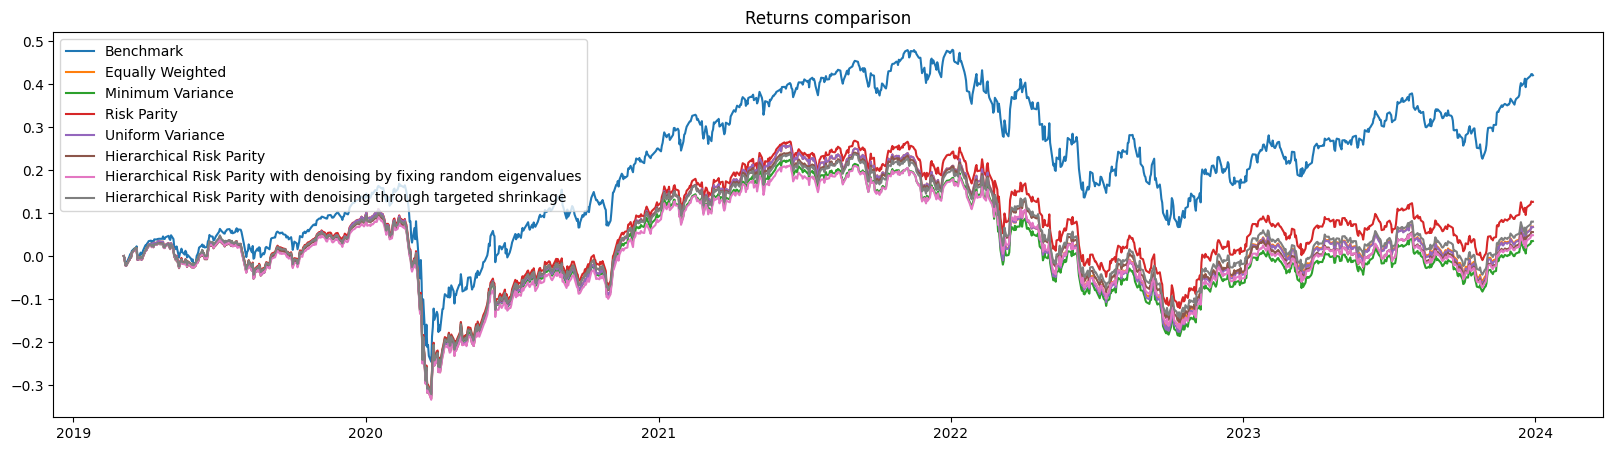

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_returns_equal, label='Equally Weighted')
plt.plot(cum_total_returns_min_var, label='Minimum Variance')
plt.plot(cum_total_returns_risk_parity, label='Risk Parity')
plt.plot(cum_total_returns_uniform_variance, label='Uniform Variance')
plt.plot(cum_total_returns_hrp, label='Hierarchical Risk Parity')
plt.plot(cum_total_returns_hrp_denoise_v1, label='Hierarchical Risk Parity with denoising by fixing random eigenvalues')
plt.plot(cum_total_returns_hrp_denoise_v2, label='Hierarchical Risk Parity with denoising through targeted shrinkage')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [23]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_equal, df_results,  'Equally Weighted', benchmark_returns)
calculate_metrics(total_returns_min_var, df_results, 'Minimum Variance', benchmark_returns)
calculate_metrics(total_returns_risk_parity, df_results, 'Risk Parity', benchmark_returns)
calculate_metrics(total_returns_uniform_variance, df_results, 'Uniform Variance', benchmark_returns)
calculate_metrics(total_returns_hrp, df_results, 'Hierarchical Risk Parity', benchmark_returns)
calculate_metrics(total_returns_hrp_denoise_v1, df_results, 'Hierarchical Risk Parity with denoising v1', benchmark_returns) # denoising by fixing random eigenvalues
calculate_metrics(total_returns_hrp_denoise_v2, df_results, 'Hierarchical Risk Parity with denoising v2', benchmark_returns) # denoising through targeted shrinkage

df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.076754,0.203326,0.377494,0.442047,-0.354829,500.0,0.216313,0
Equally Weighted,0.01443,0.210281,0.068623,0.077994,-0.397791,641.0,0.036276,-0.860219
Minimum Variance,0.007772,0.1995,0.038957,0.044053,-0.387198,641.0,0.020072,-1.024561
Risk Parity,0.025595,0.198547,0.128912,0.145848,-0.384139,583.0,0.06663,-0.804633
Uniform Variance,0.014236,0.212497,0.066995,0.07655,-0.397791,641.0,0.035788,-0.851135
Hierarchical Risk Parity,0.011968,0.19652,0.060898,0.068677,-0.381109,641.0,0.031402,-0.996636
Hierarchical Risk Parity with denoising v1,0.010503,0.196987,0.053319,0.05982,-0.389931,641.0,0.026936,-1.025014
Hierarchical Risk Parity with denoising v2,0.016751,0.196217,0.085369,0.095909,-0.384645,641.0,0.043549,-0.91433
